In [ ]:
import os
import lmdb
import pickle

split_file = "./pi1m/mmpolymer_data/PI1M/PI1M.lmdb"
env = lmdb.open(
    split_file,
    subdir=False,
    readonly=True,
    lock=False,
    readahead=False,
    meminit=False,
    max_readers=256,
)

with env.begin(write=False) as txn:
    cursor = txn.cursor()
    for key, value in cursor:
        data = pickle.loads(value)   # unpickle the stored object
        print(f"Key: {key.decode('ascii')}, Value type: {type(data)}")
        print("Value content:", data)
        break

data_list=[] # data_list will have the structure [{mol_1_num_atoms:list(..), ..., attention_mask:tensor(..)}, {mol_2..}, ...], i.e. a list of dicts (with the smiles part pre-tokenized, i.e. they are already of the type tensor.)
with env.begin() as iter_env:
    with iter_env.cursor() as curs:
        for key, value in curs:
            datapoint = pickle.loads(value) # this is a dict like {num_atoms:list(..), star_indices:[..], ..., attention_mask:tensor(..)}
            data_list.append(datapoint)
            break

Error: ./qm9/mmpolymer_data/PI1M/PI1M.lmdb: No such file or directory

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.MolStandardize import rdMolStandardize
import numpy as np
from sklearn.model_selection import GroupKFold
try:
    from sklearn.model_selection import StratifiedGroupKFold
    HAS_SGK = True
except ImportError:
    HAS_SGK = False
from rdkit.Chem import AllChem, DataStructs
from rdkit.ML.Cluster import Butina

def cluster_no_scaffold_molecules(df, radius=2, nBits=2048, cutoff=0.7):
    """
    Cluster molecules without Murcko scaffolds into pseudo-scaffold groups.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain "smiles" and "scaffold" columns.
    radius : int
        Radius for Morgan fingerprint (default = 2).
    nBits : int
        Length of fingerprint bit vector.
    cutoff : float
        Tanimoto similarity cutoff for Butina clustering.
    
    Returns
    -------
    df_out : pd.DataFrame
        With updated "scaffold" column (no-scaffold molecules assigned cluster IDs).
    """
    df = df.copy()
    no_scaf_mask = df["scaffold"].isna()
    no_scaf_df = df[no_scaf_mask]

    if no_scaf_df.empty:
        return df  # nothing to cluster

    # Compute fingerprints
    fps = []
    for smi in no_scaf_df["psmiles"]:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            fps.append(None)
            continue
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        fps.append(fp)

    # Build distance matrix for clustering
    n = len(fps)
    dists = []
    for i in range(1, n):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1 - x for x in sims])

    # Cluster with Butina
    clusters = Butina.ClusterData(dists, nPts=n, distThresh=1-cutoff, isDistData=True)

    # Assign cluster IDs
    cluster_map = {}
    for c_idx, cluster in enumerate(clusters):
        for mol_idx in cluster:
            mol_index = no_scaf_df.index[mol_idx]
            cluster_map[mol_index] = f"NOSCAF_CLUSTER_{c_idx}"

    # Update scaffold column
    for idx, scaf in cluster_map.items():
        df.at[idx, "scaffold"] = scaf

    # For unclusterable (None fingerprints), assign unique IDs
    for idx in no_scaf_df.index:
        if pd.isna(df.at[idx, "scaffold"]):
            df.at[idx, "scaffold"] = f"NOSCAF_SINGLE_{idx}"

    return df

def standardize_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    # (optional) remove salts/normalize
    frag = rdMolStandardize.FragmentParent(mol)
    norm = rdMolStandardize.Normalize(frag)
    Chem.SanitizeMol(norm)
    return Chem.MolToSmiles(norm, isomericSmiles=True, canonical=True)

def bemis_murcko_scaffold_smi(smi, include_chirality=False):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f'Molecule {smi} is None')
        return None
    scaf = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)
    return scaf if scaf else np.nan

def make_groups_from_scaffolds(smiles, include_chirality=False, standardize=True):
    std = [standardize_smiles(s) if standardize else s for s in smiles]
    scaffolds = [bemis_murcko_scaffold_smi(s, include_chirality) if s is not None else None for s in std]
    # map each unique scaffold to an integer group id
    uniq = {}
    groups = []
    for sc in scaffolds:
        if sc not in uniq:
            uniq[sc] = len(uniq)
        groups.append(uniq[sc])
    return np.array(groups), np.array(std), np.array(scaffolds)

def stratify_bins(y, n_bins=10):
    # for regression: equal-frequency bins
    y = np.asarray(y)
    quantiles = np.linspace(0, 1, n_bins + 1)
    edges = np.unique(np.quantile(y, quantiles))
    # ensure monotonic edges and at least 2 bins
    if len(edges) < 3:
        return np.zeros_like(y, dtype=int)
    return np.digitize(y, edges[1:-1], right=True)

def scaffold_kfold(smiles, y=None, k=5, seed=42, classification=False,
                   include_chirality=False, standardize=True, regression_bins=10):
    groups, std_smiles, scaffolds = make_groups_from_scaffolds(smiles, include_chirality, standardize)
    n = len(std_smiles)

    rng = np.random.default_rng(seed)
    indices = np.arange(n)
    rng.shuffle(indices)  # randomize order of groups before splitting

    if classification and y is not None and HAS_SGK:
        y_arr = np.asarray(y)
        splitter = StratifiedGroupKFold(n_splits=k, shuffle=False)
        # y must be aligned with indices passed to split
        splits = splitter.split(indices, y_arr[indices], groups[indices])
    elif (not classification) and y is not None and HAS_SGK:
        # regression: create pseudo-strata
        y_bins = stratify_bins(y, n_bins=regression_bins)
        splitter = StratifiedGroupKFold(n_splits=k, shuffle=False)
        splits = splitter.split(indices, y_bins[indices], groups[indices])
    else:
        splitter = GroupKFold(n_splits=k)
        splits = splitter.split(indices, groups=groups[indices])

    folds = []
    for fold_id, (train_idx_pos, val_idx_pos) in enumerate(splits):
        train_idx = indices[train_idx_pos]
        val_idx = indices[val_idx_pos]
        folds.append((train_idx, val_idx))
    return folds, std_smiles, scaffolds, groups

def scaffold_regression_cv_split_old_one(smiles, y, k=5, test_size=0.2, seed=42,
                                 include_chirality=False, standardize=True,
                                 regression_bins=10):
    """
    Scaffold-based regression split with fixed test set + k-fold CV on train/val.

    Returns:
        folds: list of (train_idx, val_idx)
        test_idx: indices of the test set
        std_smiles, scaffolds, groups: arrays for reference
    """
    # --- Step 1. Make groups from scaffolds ---
    groups, std_smiles, scaffolds = make_groups_from_scaffolds(
        smiles,
        include_chirality=include_chirality,
        standardize=standardize
    )
    n = len(std_smiles)
    indices = np.arange(n)

    # --- Step 2. Make stratification bins for regression ---
    y_bins = stratify_bins(y, n_bins=regression_bins)

    # --- Step 3. Scaffold-aware split into train+val vs test ---
    # Use StratifiedGroupKFold with ~1/test_size folds; take first as test
    n_splits_test = int(round(1 / test_size))
    splitter_test = StratifiedGroupKFold(n_splits=n_splits_test,
                                         shuffle=True, random_state=seed)
    train_val_idx, test_idx = next(splitter_test.split(indices, y_bins, groups))

    # --- Step 4. K-fold scaffold-aware CV on train+val ---
    splitter_cv = StratifiedGroupKFold(n_splits=k,
                                       shuffle=True, random_state=seed)
    folds = []
    for tr, val in splitter_cv.split(train_val_idx,
                                     y_bins[train_val_idx],
                                     groups[train_val_idx]):
        train_idx = train_val_idx[tr]
        val_idx = train_val_idx[val]
        folds.append((train_idx, val_idx))

    return folds, test_idx, std_smiles, scaffolds, groups

def random_folds_list(df, n_folds=5, seed=42):
    """
    Randomly splits the dataframe into n_folds and returns 5 lists of indices.

    Args:
        df (pd.DataFrame): input dataframe
        n_folds (int): number of folds
        seed (int): random seed

    Returns:
        list of lists: folds[i] contains row indices for fold i
    """
    rng = np.random.default_rng(seed)
    indices = df.index.to_numpy()
    rng.shuffle(indices)

    folds = [[] for _ in range(n_folds)]
    for i, idx in enumerate(indices):
        fold_id = i % n_folds
        folds[fold_id].append(idx)

    return folds
    
def stratified_scaffold_split(df, scaffold_col='scaffold', n_folds=5, seed=42, n_trials=50):
    """
    Assign molecules to n_folds using scaffold-based splitting with balance optimization.
    
    df: DataFrame with a 'scaffold_col' column (cluster or scaffold ID)
    scaffold_col: str, column in df with scaffold/group labels
    n_folds: int, number of folds
    seed: int, base seed for reproducibility
    n_trials: int, number of random assignments to try (pick most balanced)
    
    Returns: dict mapping fold_id -> list of indices
    """

    # Group molecules by scaffold
    scaffold_to_indices = defaultdict(list)
    for idx, scaffold in df[scaffold_col].items():
        scaffold_to_indices[scaffold].append(idx)

    scaffold_groups = list(scaffold_to_indices.items())

    best_assignment = None
    best_std = float("inf")

    rng = np.random.default_rng(seed)

    for trial in range(n_trials):
        # Shuffle scaffold order
        rng.shuffle(scaffold_groups)

        # Initialize folds
        folds = {i: [] for i in range(n_folds)}
        fold_sizes = [0] * n_folds

        # Assign each scaffold group to the fold with smallest current size
        for scaffold, indices in scaffold_groups:
            min_fold = np.argmin(fold_sizes)
            folds[min_fold].extend(indices)
            fold_sizes[min_fold] += len(indices)

        # Check balance
        std_size = np.std(fold_sizes)
        if std_size < best_std:
            best_std = std_size
            best_assignment = folds

    print(f"Best assignment std: {best_std:.2f}, fold sizes: {[len(v) for v in best_assignment.values()]}")
    return best_assignment
    
def stratified_scaffold_split_old_2(df, smiles_col="psmiles", target_col="value", n_folds=5, seed=42, n_bins=5):
    """
    Stratified scaffold split into n_folds with balanced property distribution.
    """
    rng = np.random.default_rng(seed)

    # Bin targets for stratification
    df = df.copy()
    df["bin"] = pd.qcut(df[target_col], q=n_bins, duplicates="drop")

    # Assign scaffolds
    scaffold_groups = defaultdict(list)
    for idx, smi in df[smiles_col].items():
        scaf = bemis_murcko_scaffold_smi(smi)
        if scaf is None:
            scaf = f"NO_SCAFFOLD_{idx}"
        scaffold_groups[scaf].append(idx)

    # Build scaffold metadata
    scaffold_data = []
    for scaf, indices in scaffold_groups.items():
        bins = df.loc[indices, "bin"].value_counts().to_dict()
        scaffold_data.append({
            "scaffold": scaf,
            "indices": indices,
            "size": len(indices),
            "bin_counts": bins
        })

    # **Sort by scaffold size (largest first)**
    scaffold_data.sort(key=lambda x: x["size"], reverse=True)

    # Initialize folds
    folds = {i: [] for i in range(n_folds)}
    fold_sizes = [0] * n_folds
    fold_bin_counts = [defaultdict(int) for _ in range(n_folds)]

    # Greedy assignment
    for scaf in scaffold_data:
        best_score = float("inf")
        best_fold = None
        for f in range(n_folds):
            # Size penalty dominates (avoid empty folds)
            size_penalty = fold_sizes[f]

            # Bin imbalance penalty
            bin_penalty = sum(abs((fold_bin_counts[f].get(b, 0) + scaf["bin_counts"].get(b, 0))
                                  - df["bin"].value_counts().get(b, 0) / n_folds)
                              for b in df["bin"].unique())

            score = size_penalty * 1000 + bin_penalty  # heavily prioritize balancing sizes

            if score < best_score:
                best_score = score
                best_fold = f

        folds[best_fold].extend(scaf["indices"])
        fold_sizes[best_fold] += scaf["size"]
        for b, c in scaf["bin_counts"].items():
            fold_bin_counts[best_fold][b] += c

    return folds
def stratified_scaffold_split_old(df, n_folds=5, n_bins=5, seed=42):
    """
    Perform scaffold-based stratified splitting into n_folds.
    - Approximates stratification by binning target y values.
    - Treats molecules with no scaffold as singleton scaffolds.
    
    df column names: psmiles/value/scaffold.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain ["psmiles", "scaffold", "value"] columns.
    n_folds : int
        Number of folds (default = 5).
    n_bins : int
        Number of bins for stratification of y (default = 5).
    seed : int
        Random seed for reproducibility.
    
    Returns
    -------
    folds : list of lists
        Each entry is a list of indices corresponding to one fold.
    """
    rng = np.random.default_rng(seed)

    # -----------------------------
    # Step 0. Preprocessing
    # -----------------------------

    # Treat missing scaffolds as unique singletons
    df = df.copy()
    replacement_series = pd.Series([f'NOSCAF_{i}' for i in df.index], index=df.index)
    df['scaffold'] = df['scaffold'].fillna(replacement_series)
    print(df['scaffold'])
    
    # df = df.copy()
    # df['scaffold'] = df['scaffold'].fillna('NOSCAF_' + df.index.astype(str))

    # Bin target values for stratification
    df['bin_id'] = pd.qcut(df['value'], q=n_bins, labels=False, duplicates='drop')

    # -----------------------------
    # Step 1. Prepare scaffold list
    # -----------------------------
    

    scaffolds = []
    for scaf_id, group in df.groupby('scaffold'):
        bin_counts = np.bincount(group['bin_id'], minlength=n_bins)
        scaffolds.append({
            'scaffold_id': scaf_id,
            'indices': group.index.tolist(),
            'bin_counts': bin_counts
        })

    # Shuffle scaffolds reproducibly
    rng.shuffle(scaffolds)

    # rng = np.random.default_rng(seed)
    scaffolds = rng.permutation(scaffolds)

    # -----------------------------
    # Step 2. Initialize folds
    # -----------------------------
    folds = [[] for _ in range(n_folds)]
    fold_bin_counts = [np.zeros(n_bins, dtype=int) for _ in range(n_folds)]
    fold_sizes = [0] * n_folds

    # Compute global ideal bin distribution
    total_bin_counts = np.bincount(df['bin_id'], minlength=n_bins)
    ideal_per_fold = total_bin_counts / n_folds

    # -----------------------------
    # Step 3. Assign scaffolds
    # -----------------------------
    for scaf in scaffolds:
        best_fold = None
        best_score = None
        for f in range(n_folds):
            # Candidate bin counts if scaffold assigned to this fold
            cand_bin_counts = fold_bin_counts[f] + scaf['bin_counts']

            # Score = imbalance to ideal
            score = np.sum(np.abs(cand_bin_counts - ideal_per_fold))

            # Tie-break: use fold size
            if (best_score is None or
                score < best_score or
                (np.isclose(score, best_score) and fold_sizes[f] < fold_sizes[best_fold])):
                best_score = score
                best_fold = f

        # Assign scaffold to chosen fold
        folds[best_fold].extend(scaf['indices'])
        fold_bin_counts[best_fold] += scaf['bin_counts']
        fold_sizes[best_fold] += len(scaf['indices'])

    # -----------------------------
    # Step 4. Return folds
    # -----------------------------
    return folds


def stratified_scaffold_split_balanced_postprocess(df, n_folds=5, n_bins=5, seed=42, n_trials=50):
    """
    Scaffold-based stratified splitting with roughly equal fold sizes.
    - Treats no-scaffold molecules as singletons.
    - Uses target binning for stratification.
    - Redistributes fold excess if any fold is much larger than the mean.
    
    Returns:
        folds: list of lists of indices
    """
    rng = np.random.default_rng(seed)
    df = df.copy()

    # Step 0: singleton replacement
    replacement_series = pd.Series([f'NOSCAF_{i}' for i in df.index], index=df.index)
    df['scaffold'] = df['scaffold'].fillna(replacement_series)

    # Bin target values
    df['bin_id'] = pd.qcut(df['value'], q=n_bins, labels=False, duplicates='drop')

    # Step 1: prepare scaffold list
    scaffolds = []
    for scaf_id, group in df.groupby('scaffold'):
        bin_counts = np.bincount(group['bin_id'], minlength=n_bins)
        scaffolds.append({
            'scaffold_id': scaf_id,
            'indices': group.index.tolist(),
            'bin_counts': bin_counts
        })

    best_assignment = None
    best_std = np.inf

    # Step 2: multiple trials to optimize
    for trial in range(n_trials):
        rng.shuffle(scaffolds)
        folds = [[] for _ in range(n_folds)]
        fold_bin_counts = [np.zeros(n_bins, dtype=int) for _ in range(n_folds)]
        fold_sizes = [0] * n_folds
        total_bin_counts = np.bincount(df['bin_id'], minlength=n_bins)
        ideal_per_fold = total_bin_counts / n_folds

        for scaf in scaffolds:
            best_fold = None
            best_score = None
            for f in range(n_folds):
                cand_bin_counts = fold_bin_counts[f] + scaf['bin_counts']
                score = np.sum(np.abs(cand_bin_counts - ideal_per_fold)) + 0.01 * fold_sizes[f]

                if (best_score is None or score < best_score):
                    best_score = score
                    best_fold = f

            folds[best_fold].extend(scaf['indices'])
            fold_bin_counts[best_fold] += scaf['bin_counts']
            fold_sizes[best_fold] += len(scaf['indices'])

        # Step 2b: record best assignment by std fold size
        std_size = np.std(fold_sizes)
        if std_size < best_std:
            best_std = std_size
            best_assignment = folds

    # Step 3: post-process to redistribute excess
    fold_sizes = np.array([len(f) for f in best_assignment])
    mean_size = int(np.mean(fold_sizes))

    # While any fold is bigger than mean+1, move excess molecules to smaller folds
    changed = True
    while changed:
        changed = False
        fold_sizes = np.array([len(f) for f in best_assignment])
        for i, f in enumerate(best_assignment):
            if len(f) > mean_size:
                excess = len(f) - mean_size
                # Find folds smaller than mean
                smaller_folds = [j for j, size in enumerate(fold_sizes) if size < mean_size]
                if not smaller_folds:
                    continue
                # Redistribute roughly evenly
                for j in smaller_folds:
                    move_count = min(excess, mean_size - len(best_assignment[j]))
                    if move_count <= 0:
                        continue
                    best_assignment[j].extend(f[:move_count])
                    del f[:move_count]
                    changed = True
                    excess -= move_count
                    if excess <= 0:
                        break

    final_sizes = [len(f) for f in best_assignment]
    print(f"Final fold sizes after redistribution: {final_sizes}")
    return best_assignment

In [3]:
import os
import pandas as pd
from rdkit.Chem.Scaffolds import MurckoScaffold
import collections
os.getcwd()

fold_data_folder = "../MMPolymer/MMPolymer/dataset/fold_data/"
data = "../MMPolymer/MMPolymer/dataset/data/Egc.csv"
data = pd.read_csv(data)

data['scaffold'] = data['psmiles'].map(bemis_murcko_scaffold_smi)

data_no_cluster = data.copy(deep=True)
data_random = data.copy(deep=True)

# for i in data['scaffold']:
#     print(i)
data = cluster_no_scaffold_molecules(data, radius=2, nBits=2048, cutoff=0.5)

noscafs=[]
o=0
for i in data['scaffold']: 
    if 'NOSCAF' in i:
        noscafs.append(i)
        # print(i)
        if int(i.split('_')[-1])>o:
            o=int(i.split('_')[-1])
print(f'Number of created clusters for no-scaffold mols: {len(np.unique(noscafs))}')

folds = stratified_scaffold_split(data, n_folds=5, seed=42)
folds_no_cluster = stratified_scaffold_split_balanced_postprocess(data_no_cluster, n_folds=5, seed=42)#, n_trials=250)
folds_random = random_folds_list(data_random, n_folds=5, seed=42)

if isinstance(folds,list):
    folds = {k:v for k,v in enumerate(folds)}
if isinstance(folds_no_cluster,list):
    folds_no_cluster = {k:v for k,v in enumerate(folds_no_cluster)}
if isinstance(folds_random,list):
    folds_random = {k:v for k,v in enumerate(folds_random)}

# all three need to be dict
assert all([isinstance(fold_obj,dict) for fold_obj in [folds, folds_no_cluster, folds_random]])

# df['fold'] = -1  # or np.nan

#     # Assign fold IDs
# for indices in folds_random:
#     df.loc[indices, 'fold'] = fold_id

for df, fold_list in zip([data, data_no_cluster, data_random], [folds, folds_no_cluster, folds_random]):
    df['fold'] = -1  # or np.nan

    # Assign fold IDs
    for fold_id, indices in fold_list.items():
        df.loc[indices, 'fold'] = fold_id

# train_idxs
# valid_idxs
# test_idxs



[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerator
[02:54:16] DEPRECATION WARNING: please use MorganGenerat

Number of created clusters for no-scaffold mols: 302
Best assignment std: 0.00, fold sizes: [676, 676, 676, 676, 676]
Final fold sizes after redistribution: [676, 676, 676, 676, 676]


In [4]:
for df in [folds, data_no_cluster, data_random]: 
    print('new df: ')
    for fold in folds.values():
        print(len(fold))

print(collections.Counter(data['scaffold']))



new df: 
676
676
676
676
676
new df: 
676
676
676
676
676
new df: 
676
676
676
676
676
Counter({'c1ccccc1': 420, 'NOSCAF_CLUSTER_0': 234, 'c1ccsc1': 120, 'C1CCCCC1': 65, 'NOSCAF_CLUSTER_1': 65, 'c1ccc(Cc2ccccc2)cc1': 35, 'NOSCAF_CLUSTER_7': 35, 'NOSCAF_CLUSTER_2': 33, 'NOSCAF_CLUSTER_3': 30, 'c1ccc(-c2ccccc2)cc1': 30, 'c1ccncc1': 29, 'NOSCAF_CLUSTER_6': 28, 'c1csc(-c2cccs2)c1': 27, 'c1cc[nH]c1': 26, 'C1CNCCN1': 21, 'C1CCCC1': 20, 'NOSCAF_CLUSTER_17': 19, 'c1ccc(-c2cccs2)cc1': 19, 'NOSCAF_CLUSTER_23': 18, 'NOSCAF_CLUSTER_8': 18, 'c1ccc2c(c1)[nH]c1ccccc12': 17, 'NOSCAF_CLUSTER_24': 17, 'O=C(Nc1ccccc1)c1ccccc1': 16, 'C1CC2OCCC2O1': 14, 'c1ccc2ccccc2c1': 13, 'NOSCAF_CLUSTER_30': 13, 'NOSCAF_CLUSTER_18': 13, 'O=C(Oc1ccccc1)c1ccccc1': 13, 'C1CCOCC1': 13, 'NOSCAF_CLUSTER_26': 12, 'NOSCAF_CLUSTER_31': 12, 'NOSCAF_CLUSTER_14': 12, 'c1ccc(N=Nc2ccccc2)cc1': 12, 'NOSCAF_CLUSTER_34': 11, 'O=c1[nH]c(=O)c2cc3c(=O)[nH]c(=O)c3cc12': 11, 'NOSCAF_CLUSTER_39': 10, 'NOSCAF_CLUSTER_35': 10, 'NOSCAF_CLUSTER_

In [5]:
# NOTE: no matter what the clustering cutoff is set to, the distribution of clusters over the 5 folds will be somewhat similar; however,
#       the bigger each cluster (so less clusters per fold), the more molecules are grouped together in the same fold that could (according to fingerprint)
#       be similar; this means that it should be less likely that similar molecules leak to test folds. Lower cutoffs (bigger cluster), thus means that
#       test performance on 5 fold CV could reduce, in other words the task could become more difficult. We pick 0.5 for a balanced choice in this now.
scaf_dict={0:[],1:[],2:[],3:[],4:[]}
for sca,fol in zip(data['scaffold'], data['fold']): # {"data":data,"data_no_cluster":data_no_cluster,"data_random":data_random}.items():
    # print(sca,fol)
    # print(f"dataset {n}:")
    # for el in df['scaffold']:
        # print(el)
    # if not isinstance(fol,int):
    # print(scaf_dict[fol])
    if 'NOSCAF_CLUSTER' in str(sca):
        scaf_dict[fol].append(sca)
    # if 'NOSCAF_CLUSTER' in str(sca):
        # scaf_dict[fold]=scaf_dict[fold].append(sca)
                # print(el)
print('nr. of unassigned scaffold clusters per each of the 5 folds:')
[len(set(scafs)) for scafs in scaf_dict.values()]

nr. of unassigned scaffold clusters per each of the 5 folds:


[38, 87, 89, 24, 64]

In [6]:
data

psmiles   value  \
0                                              *C*  6.8972   
1                                          *CC(*)C  6.5196   
2                                         *CC(*)CC  6.5170   
3                                        *CC(*)CCC  6.7336   
4                                     *CC(*)CC(C)C  6.7394   
...                                            ...     ...   
3375           *Nc1c([2H])c([2H])c(*)c([2H])c1[2H]  3.3666   
3376               *CCCCCC[N+](C)(C)CCC[N+](*)(C)C  0.2161   
3377          *CCCCCCCC[N+](C)(C)CCCCCC[N+](*)(C)C  0.1032   
3378  *CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](*)(C)C  0.1771   
3379       *C=Cc1cc([Si](C)(C)C)c(*)cc1[Si](C)(C)C  2.2084   

                scaffold  fold  
0     NOSCAF_CLUSTER_301     3  
1     NOSCAF_CLUSTER_300     0  
2     NOSCAF_CLUSTER_150     2  
3     NOSCAF_CLUSTER_150     2  
4     NOSCAF_CLUSTER_299     4  
...                  ...   ...  
3375            c1ccccc1     3  
3376   NOSCAF_CLUSTER_74     1  
3377   NOSCAF_CLUSTER_74     1  
3378   NOSCAF_CLUSTER_74     1  
3379            c1ccccc1     3  

[3380 rows x 4 columns]

In [9]:
# len(set(data_random['scaffold']))
# folds

def folds_to_csvs(folds_dict, df, data_name, seed=42, output_dir="."):
    '''
    take dictionary containing the indices of which molecules of a given dataset should go into which fold,
    
    resulting in saving csv files to input folder as 'dataset/egc_fold1_train/val', .., etc;
    
    saves train/validation/test for 4-fold inner CV with 1 fixed test fold;

    Parameters
    ----------
    folds_dict : dict
        Dictionary {0:[indices], ..., 4:[indices]} containing fold indices.
    df : pd.DataFrame
        Dataframe with at least ['psmiles','value'] columns.
    data_name : str
        Name of the dataset (used in filenames).
    seed : int
        Random seed for selecting the held-out test fold.
    output_dir : str
        Directory to save the CSV files.
    '''
    
    rng = np.random.default_rng(seed)

    # Step 1: randomly choose one fold as the held-out test fold
    all_fold_ids = list(folds_dict.keys())
    test_fold = rng.choice(all_fold_ids)
    print(f"Held-out test fold: {test_fold}")

    # Remaining folds for train/validation rotation
    remaining_folds = [f for f in all_fold_ids if f != test_fold]
    print('remaining folds: ', remaining_folds)

    # Step 2: iterate over 4 rotations of validation fold
    for split_id, val_fold in enumerate(remaining_folds):
        # Train folds = all remaining folds except the current validation fold
        train_folds = [f for f in remaining_folds if f != val_fold]
        print(f'current val fold: {val_fold}, current training folds: {train_folds}')

        # Build dataframes
        # print('df: ', df)
        train_indices = sum([folds_dict[f] for f in train_folds], [])
        # print('train_indices', train_indices)
        val_indices = folds_dict[val_fold]
        
        test_indices = folds_dict[test_fold]

        df_train = df.loc[train_indices, ['psmiles','value']].reset_index(drop=True)
        df_val = df.loc[val_indices, ['psmiles','value']].reset_index(drop=True)
        df_test = df.loc[test_indices, ['psmiles','value']].reset_index(drop=True)
        print(f'length train df: {len(df_train)}, length val df: {len(df_val)}, length test df: {len(df_test)}')

        # Step 3: save CSVs
        for split_type, split_df in zip(['train','val','test'], [df_train, df_val, df_test]):
            file_name = f"{data_name}_testfold_{test_fold}_split_{split_id}_{split_type}.csv"
            print(f'saving {split_type} split under file name: {file_name}')

            file_dir = os.path.join(
                output_dir,
                f'splitting_{split_id}' 
            )
            # if dir doesn't exist, make it
            if not os.path.exists(file_dir):
                os.makedirs(file_dir)

            filename = os.path.join(file_dir, file_name)
            
            split_df.to_csv(filename, index=False)

        print(f"Saved split {split_id}: val_fold={val_fold}, train_folds={train_folds}")


# run for 3 CV strategies and 8 datasets (result: 3*8*4(cv options)*3(the splits) datasets)
fold_strategies = {'cluster':folds,'no_cluster':folds_no_cluster,'random':folds_random}
data_names = ["Eat","Eea","Egb","Egc","Ei","EPS","Nc","Xc",]
cv_dir_orig = "../MMPolymer/MMPolymer/dataset/"

for fold_strategy,fold_dict in fold_strategies.items():
    cv_dir = os.path.join(cv_dir_orig, 'data_cv_'+fold_strategy)
    for data_name in data_names:
        dataset_orig_dir = os.path.join(cv_dir_orig, 'data', f'{data_name}.csv')
        print('dataset_orig_dir: ', dataset_orig_dir)
        
        # load dataset and create folds dict
        df = pd.read_csv(dataset_orig_dir)
        df['scaffold'] = df['psmiles'].map(bemis_murcko_scaffold_smi)

        if fold_strategy=='cluster':
            df = cluster_no_scaffold_molecules(df, radius=2, nBits=2048, cutoff=0.5)
            fold_dict = stratified_scaffold_split(df, n_folds=5, seed=42)
        elif fold_strategy=='no_cluster':
            fold_dict = stratified_scaffold_split_balanced_postprocess(df, n_folds=5, seed=42)#, n_trials=250)
        elif fold_strategy=='random':            
            fold_dict = random_folds_list(df, n_folds=5, seed=42)

        if isinstance(fold_dict,list):
            fold_dict = {k:v for k,v in enumerate(fold_dict)}
        
        # needs to be dict
        assert isinstance(fold_dict,dict)

        # assign fold IDs in new col
        df['fold'] = -1  # or np.nan
        for fold_id, indices in fold_dict.items():
            df.loc[indices, 'fold'] = fold_id

        # set output dir and run csv transform.
        dataset_dir = os.path.join(cv_dir, data_name)
        
        folds_to_csvs(fold_dict, df, data_name, seed=42, output_dir=dataset_dir)


dataset_orig_dir:  ../MMPolymer/MMPolymer/dataset/data/Eat.csv
Best assignment std: 1.41, fold sizes: [78, 76, 80, 79, 77]
Held-out test fold: 0
remaining folds:  [1, 2, 3, 4]
current val fold: 1, current training folds: [2, 3, 4]
length train df: 236, length val df: 76, length test df: 78
saving train split under file name: Eat_testfold_0_split_0_train.csv
saving val split under file name: Eat_testfold_0_split_0_val.csv
saving test split under file name: Eat_testfold_0_split_0_test.csv
Saved split 0: val_fold=1, train_folds=[2, 3, 4]
current val fold: 2, current training folds: [1, 3, 4]
length train df: 232, length val df: 80, length test df: 78
saving train split under file name: Eat_testfold_0_split_1_train.csv
saving val split under file name: Eat_testfold_0_split_1_val.csv
saving test split under file name: Eat_testfold_0_split_1_test.csv
Saved split 1: val_fold=2, train_folds=[1, 3, 4]
current val fold: 3, current training folds: [1, 2, 4]
length train df: 233, length val df: 79

[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerat

Best assignment std: 0.40, fold sizes: [112, 112, 112, 113, 112]
Held-out test fold: 0
remaining folds:  [1, 2, 3, 4]
current val fold: 1, current training folds: [2, 3, 4]
length train df: 337, length val df: 112, length test df: 112
saving train split under file name: Egb_testfold_0_split_0_train.csv
saving val split under file name: Egb_testfold_0_split_0_val.csv
saving test split under file name: Egb_testfold_0_split_0_test.csv
Saved split 0: val_fold=1, train_folds=[2, 3, 4]
current val fold: 2, current training folds: [1, 3, 4]
length train df: 337, length val df: 112, length test df: 112
saving train split under file name: Egb_testfold_0_split_1_train.csv
saving val split under file name: Egb_testfold_0_split_1_val.csv
saving test split under file name: Egb_testfold_0_split_1_test.csv
Saved split 1: val_fold=2, train_folds=[1, 3, 4]
current val fold: 3, current training folds: [1, 2, 4]
length train df: 336, length val df: 113, length test df: 112
saving train split under file n

[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerator
[02:58:18] DEPRECATION WARNING: please use MorganGenerat

Best assignment std: 0.00, fold sizes: [676, 676, 676, 676, 676]
Held-out test fold: 0
remaining folds:  [1, 2, 3, 4]
current val fold: 1, current training folds: [2, 3, 4]
length train df: 2028, length val df: 676, length test df: 676
saving train split under file name: Egc_testfold_0_split_0_train.csv
saving val split under file name: Egc_testfold_0_split_0_val.csv
saving test split under file name: Egc_testfold_0_split_0_test.csv
Saved split 0: val_fold=1, train_folds=[2, 3, 4]
current val fold: 2, current training folds: [1, 3, 4]
length train df: 2028, length val df: 676, length test df: 676
saving train split under file name: Egc_testfold_0_split_1_train.csv
saving val split under file name: Egc_testfold_0_split_1_val.csv
saving test split under file name: Egc_testfold_0_split_1_test.csv
Saved split 1: val_fold=2, train_folds=[1, 3, 4]
current val fold: 3, current training folds: [1, 2, 4]
length train df: 2028, length val df: 676, length test df: 676
saving train split under fil

[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerat

Best assignment std: 1.02, fold sizes: [76, 78, 76, 77, 75]
Held-out test fold: 0
remaining folds:  [1, 2, 3, 4]
current val fold: 1, current training folds: [2, 3, 4]
length train df: 228, length val df: 78, length test df: 76
saving train split under file name: Nc_testfold_0_split_0_train.csv
saving val split under file name: Nc_testfold_0_split_0_val.csv
saving test split under file name: Nc_testfold_0_split_0_test.csv
Saved split 0: val_fold=1, train_folds=[2, 3, 4]
current val fold: 2, current training folds: [1, 3, 4]
length train df: 230, length val df: 76, length test df: 76
saving train split under file name: Nc_testfold_0_split_1_train.csv
saving val split under file name: Nc_testfold_0_split_1_val.csv
saving test split under file name: Nc_testfold_0_split_1_test.csv
Saved split 1: val_fold=2, train_folds=[1, 3, 4]
current val fold: 3, current training folds: [1, 2, 4]
length train df: 229, length val df: 77, length test df: 76
saving train split under file name: Nc_testfold_

[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerator
[02:58:19] DEPRECATION WARNING: please use MorganGenerat

Final fold sizes after redistribution: [78, 78, 78, 78, 78]
Held-out test fold: 0
remaining folds:  [1, 2, 3, 4]
current val fold: 1, current training folds: [2, 3, 4]
length train df: 234, length val df: 78, length test df: 78
saving train split under file name: Eat_testfold_0_split_0_train.csv
saving val split under file name: Eat_testfold_0_split_0_val.csv
saving test split under file name: Eat_testfold_0_split_0_test.csv
Saved split 0: val_fold=1, train_folds=[2, 3, 4]
current val fold: 2, current training folds: [1, 3, 4]
length train df: 234, length val df: 78, length test df: 78
saving train split under file name: Eat_testfold_0_split_1_train.csv
saving val split under file name: Eat_testfold_0_split_1_val.csv
saving test split under file name: Eat_testfold_0_split_1_test.csv
Saved split 1: val_fold=2, train_folds=[1, 3, 4]
current val fold: 3, current training folds: [1, 2, 4]
length train df: 234, length val df: 78, length test df: 78
saving train split under file name: Eat_te

In [ ]:
# ["../MMPolymer/MMPolymer/dataset/data/Eat.csv",
# "../MMPolymer/MMPolymer/dataset/data/Eea.csv",
# "../MMPolymer/MMPolymer/dataset/data/Egb.csv",
# "../MMPolymer/MMPolymer/dataset/data/Egc.csv",
# "../MMPolymer/MMPolymer/dataset/data/Ei.csv",
# "../MMPolymer/MMPolymer/dataset/data/EPS.csv",
# "../MMPolymer/MMPolymer/dataset/data/Nc.csv",
# "../MMPolymer/MMPolymer/dataset/data/PI1M.csv",
# "../MMPolymer/MMPolymer/dataset/data/Xc.csv",]



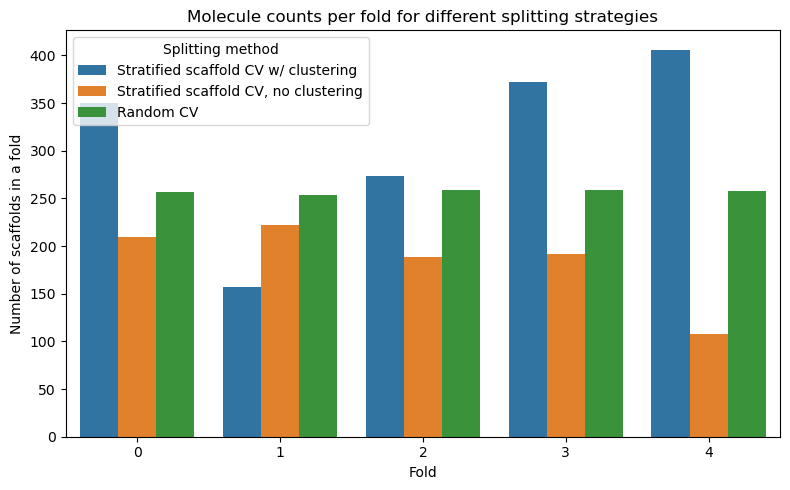

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example counts
cluster_counts = {0: 350, 1: 157, 2: 274, 3: 372, 4: 406}
no_cluster_counts = {0: 210, 1: 222, 2: 189, 3: 192, 4: 108}
random_counts = {0: 257, 1: 254, 2: 259, 3: 259, 4: 258}


# Convert to DataFrame in long format for seaborn
data_bars = []
for fold in cluster_counts:
    data_bars.append({"Fold": fold, "Count": cluster_counts[fold], "Type": "Stratified scaffold CV w/ clustering"})
    data_bars.append({"Fold": fold, "Count": no_cluster_counts[fold], "Type": "Stratified scaffold CV, no clustering"})
    data_bars.append({"Fold": fold, "Count": random_counts[fold], "Type": "Random CV"})

df_plot = pd.DataFrame(data_bars)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=df_plot, x="Fold", y="Count", hue="Type")
plt.title("Molecule counts per fold for different splitting strategies")
plt.ylabel("Number of scaffolds in a fold")
plt.xlabel("Fold")
plt.legend(title="Splitting method")
plt.tight_layout()
plt.show()

In [284]:
for df in [data, data_no_cluster, data_random]:
    print({fold:len(uniq) for fold,uniq in df.groupby(['fold']).scaffold.unique().items()}) # {0: 350, 1: 157, 2: 274, 3: 372, 4: 406}


{0: 350, 1: 157, 2: 274, 3: 372, 4: 406}
{0: 210, 1: 222, 2: 189, 3: 192, 4: 108}
{0: 257, 1: 254, 2: 259, 3: 259, 4: 258}


In [290]:
data

psmiles   value  \
0                                              *C*  6.8972   
1                                          *CC(*)C  6.5196   
2                                         *CC(*)CC  6.5170   
3                                        *CC(*)CCC  6.7336   
4                                     *CC(*)CC(C)C  6.7394   
...                                            ...     ...   
3375           *Nc1c([2H])c([2H])c(*)c([2H])c1[2H]  3.3666   
3376               *CCCCCC[N+](C)(C)CCC[N+](*)(C)C  0.2161   
3377          *CCCCCCCC[N+](C)(C)CCCCCC[N+](*)(C)C  0.1032   
3378  *CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](*)(C)C  0.1771   
3379       *C=Cc1cc([Si](C)(C)C)c(*)cc1[Si](C)(C)C  2.2084   

                scaffold  fold  
0     NOSCAF_CLUSTER_644     3  
1     NOSCAF_CLUSTER_643     4  
2     NOSCAF_CLUSTER_642     2  
3     NOSCAF_CLUSTER_641     0  
4     NOSCAF_CLUSTER_640     4  
...                  ...   ...  
3375            c1ccccc1     1  
3376   NOSCAF_CLUSTER_44     1  
3377   NOSCAF_CLUSTER_44     1  
3378   NOSCAF_CLUSTER_44     1  
3379            c1ccccc1     1  

[3380 rows x 4 columns]

<Figure size 640x480 with 0 Axes>

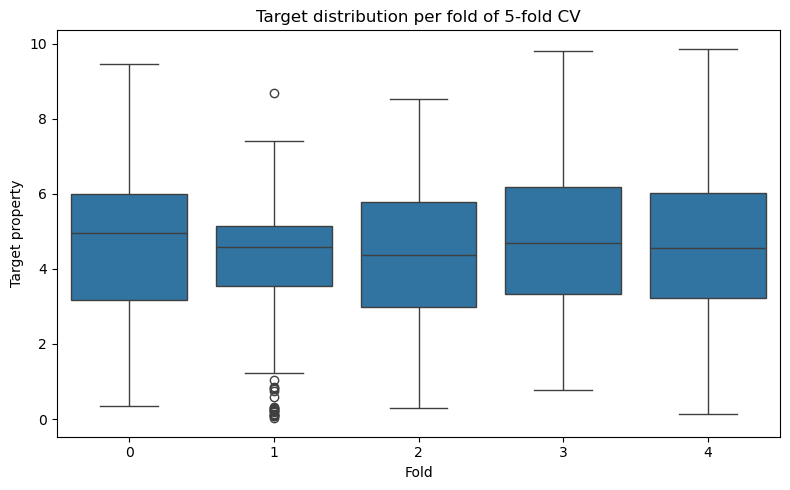

<Figure size 640x480 with 0 Axes>

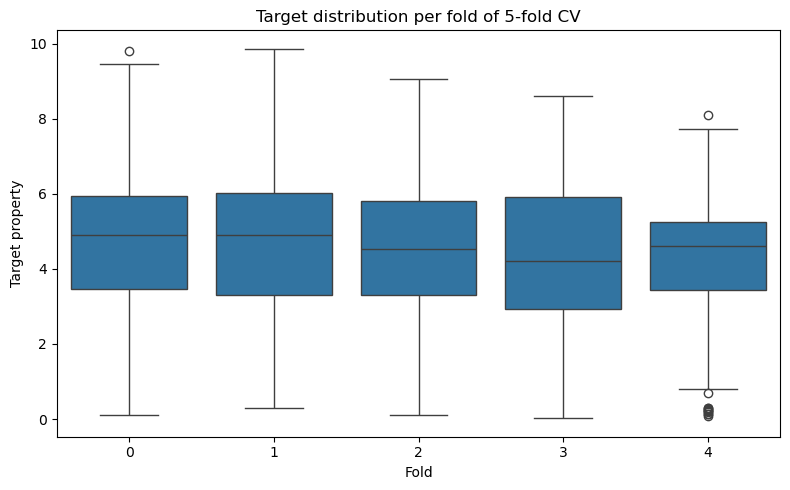

<Figure size 640x480 with 0 Axes>

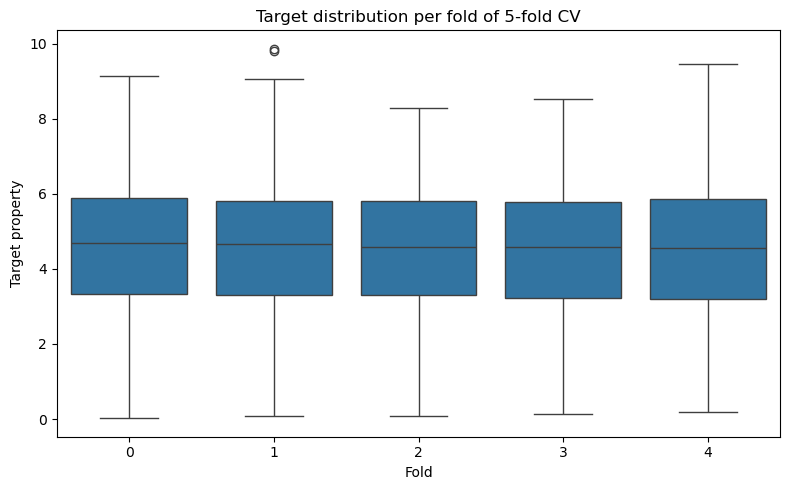

In [295]:
# penguins = sns.load_dataset("penguins")
import seaborn as sns

for df in [data, data_no_cluster, data_random]:
    plt.clf()
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x="fold", y="value")
    plt.title("Target distribution per fold of 5-fold CV")
    plt.ylabel("Target property")
    plt.xlabel("Fold")
    # plt.legend(title="Splitting method")
    plt.tight_layout()
    plt.show()
# for fold in folds.values():
#     sns.histplot(data=data.iloc[fold], x="value")

# data.iloc[folds[4]].value #data.iloc[folds[3]].value)    #),len(data.iloc[folds[0]].scaffold.unique())

In [102]:
data['scaffold'].unique()

array(['NOSCAF_CLUSTER_25', 'NOSCAF_CLUSTER_13', 'NOSCAF_CLUSTER_22', ...,
       'c1cc(-c2cc[nH+]cc2)cc[nH+]1', 'C1CC[NH2+]CC1',
       'c1ccc2c(c1)Nc1ccccc1[SiH2]2'], dtype=object)

In [52]:
data.index.astype(str)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '3370', '3371', '3372', '3373', '3374', '3375', '3376', '3377', '3378',
       '3379'],
      dtype='object', length=3380)

In [ ]:
### check existing splits
data_train = "../MMPolymer/MMPolymer/dataset/data/Egc/Egc_train.csv" # now we we want ../fold_data/Egb_1/Egb_train.csv, ..., Egb_2/Egb_train.csv, .. and so on;
data_train = pd.read_csv(data_train)

data_valid = "../MMPolymer/MMPolymer/dataset/data/Egc/Egc_valid.csv"
data_valid = pd.read_csv(data_valid)

data_test = "../MMPolymer/MMPolymer/dataset/data/Egc/Egc_test.csv"
data_test = pd.read_csv(data_test)

train_idxs = []
test_idxs = []
valid_idxs = []

train_scaffolds = []
test_scaffolds = []
valid_scaffolds = []


for i,smiles in enumerate(data['psmiles']):

    if smiles in data_train['psmiles'].values:
        # print('train')
        train_idxs.append(i)
        scaff=MurckoScaffold.MurckoScaffoldSmiles(smiles=smiles, includeChirality=True)
        if scaff=='':
            print('empty scaffold for: ', smiles)
        train_scaffolds.append(scaff)
    if smiles in data_valid['psmiles'].values:
        valid_idxs.append(i)
        valid_scaffolds.append(MurckoScaffold.MurckoScaffoldSmiles(smiles=smiles, includeChirality=True))
        # print('valid')
    if smiles in data_test['psmiles'].values:
        test_idxs.append(i)
        test_scaffolds.append(MurckoScaffold.MurckoScaffoldSmiles(smiles=smiles, includeChirality=True))
        # print('test')

# assert no duplicates between splits
assert len(list(set(train_idxs) & set(valid_idxs)))==0
assert len(list(set(train_idxs) & set(test_idxs)))==0
assert len(list(set(valid_idxs) & set(test_idxs)))==0

In [46]:
noscafs

['NOSCAF_CLUSTER_25',
 'NOSCAF_CLUSTER_13',
 'NOSCAF_CLUSTER_22',
 'NOSCAF_CLUSTER_22',
 'NOSCAF_CLUSTER_13',
 'NOSCAF_CLUSTER_34',
 'NOSCAF_CLUSTER_34',
 'NOSCAF_CLUSTER_81',
 'NOSCAF_CLUSTER_14',
 'NOSCAF_CLUSTER_14',
 'NOSCAF_CLUSTER_14',
 'NOSCAF_CLUSTER_14',
 'NOSCAF_CLUSTER_34',
 'NOSCAF_CLUSTER_14',
 'NOSCAF_CLUSTER_46',
 'NOSCAF_CLUSTER_22',
 'NOSCAF_CLUSTER_22',
 'NOSCAF_CLUSTER_25',
 'NOSCAF_CLUSTER_13',
 'NOSCAF_CLUSTER_5',
 'NOSCAF_CLUSTER_5',
 'NOSCAF_CLUSTER_5',
 'NOSCAF_CLUSTER_19',
 'NOSCAF_CLUSTER_12',
 'NOSCAF_CLUSTER_46',
 'NOSCAF_CLUSTER_42',
 'NOSCAF_CLUSTER_5',
 'NOSCAF_CLUSTER_44',
 'NOSCAF_CLUSTER_44',
 'NOSCAF_CLUSTER_5',
 'NOSCAF_CLUSTER_44',
 'NOSCAF_CLUSTER_22',
 'NOSCAF_CLUSTER_33',
 'NOSCAF_CLUSTER_67',
 'NOSCAF_CLUSTER_67',
 'NOSCAF_CLUSTER_33',
 'NOSCAF_CLUSTER_22',
 'NOSCAF_CLUSTER_12',
 'NOSCAF_CLUSTER_19',
 'NOSCAF_CLUSTER_19',
 'NOSCAF_CLUSTER_19',
 'NOSCAF_CLUSTER_12',
 'NOSCAF_CLUSTER_5',
 'NOSCAF_CLUSTER_22',
 'NOSCAF_CLUSTER_5',
 'NOSCAF_CLUSTER_

In [42]:
MurckoScaffold.MurckoScaffoldSmiles(smiles="NC(C)C(=O)NC(C)C(=O)NC(C(=O)NC(C(C)=O)C(C)C)C(C)C", includeChirality=True)

''

In [2]:
sum([len(a) for a in set(test_scaffolds)]) / len([len(a) for a in set(test_scaffolds)])


# choose 4 (more) times random scaffolds to fill the split lists with, 
# making sure every list of molecules is of the correct length.;

43.9112426035503

In [3]:

# test_scaffolds#+valid_scaffolds+test_scaffolds)

counter_train = collections.Counter(train_scaffolds)
counter_valid = collections.Counter(valid_scaffolds)
counter_test = collections.Counter(test_scaffolds)
counter_train

Counter({'': 1109,
         'C1CCCC1': 20,
         'C1CCCCC1': 65,
         'C1CCC1': 7,
         'c1ccccc1': 420,
         'O=C(c1ccccc1)c1ccccc1': 9,
         'c1ccc2ccccc2c1': 13,
         'c1ccncc1': 29,
         'c1ccc2n[nH]cc2c1': 2,
         'c1ccc2c(c1)[nH]c1ccccc12': 17,
         'c1ccsc1': 120,
         'c1ncncn1': 6,
         'O=C1CCC(=O)O1': 4,
         'c1c[nH]cn1': 5,
         'O=C1CCCN1': 2,
         'C1CCOC1': 4,
         'C1=CCCCC1': 5,
         'C1=CCCC1': 2,
         'c1ccc(-c2cccc(-c3ccccc3)c2)cc1': 2,
         'c1ccc(Cc2ccccc2)cc1': 35,
         'c1ccc(Sc2ccccc2)cc1': 2,
         'c1ccoc1': 9,
         'C1CNCCN1': 21,
         'O=C(OC(=O)c1ccccc1)c1ccccc1': 8,
         'c1ccc(Oc2ccccc2)cc1': 7,
         'O=S(=O)(c1ccccc1)c1ccccc1': 2,
         'c1ccc(Oc2ccc(-c3cnc4ccc(-c5ccc6nccnc6c5)cc4n3)cc2)cc1': 2,
         'c1ccc(Oc2ccc(-c3cnc4cc5nccnc5cc4n3)cc2)cc1': 2,
         'c1ccc(-c2cnc3ccc(Oc4ccc5nc(-c6ccccc6)c(-c6ccccc6)nc5c4)cc3n2)cc1': 2,
         'C1COCOC1': 6,
  

In [32]:
counter_valid # 448/56/57 instances in Egb

Counter({'C1CC1': 2,
         'C1COCO1': 2,
         'C1CNCCN1': 2,
         'O=C(c1ccccc1)c1ccccc1': 3,
         'C1CC2C3CCC(C3)C2C1': 2,
         'C1CC2OCCC2O1': 3,
         'c1cc[nH]c1': 2,
         'S=C(c1cccs1)c1cccs1': 3,
         'c1csc(Oc2cccs2)c1': 4,
         'c1ccc(-c2ccc(-c3cccs3)s2)cc1': 3,
         'c1ccc(-c2ccc(-c3cccs3)cc2)cc1': 3,
         'S=C(c1ccccc1)c1cccs1': 4,
         'S=C(c1ccccc1)c1ccccc1': 4,
         'c1ccc(Oc2cccs2)cc1': 4,
         'c1ccc(Oc2ccccc2)cc1': 2,
         'c1csc(-c2ccc(-c3cccs3)cc2)c1': 3,
         'c1csc(Cc2cccs2)c1': 2,
         'O=C(c1cccs1)c1cccs1': 3,
         'c1csc(Nc2cccs2)c1': 2,
         'c1ccc(Cc2cccs2)cc1': 2,
         'S=C(Nc1cccs1)Oc1ccc(Nc2cccs2)s1': 1})

In [22]:
counter_test

Counter({'C1CCC1': 2,
         'O=C1CCCN1': 1,
         'O=C1CCC(=O)O1': 1,
         'C1=CCCCC1': 1,
         'c1ccc(SSCCCCCCCCCCSSc2ccccc2)cc1': 1,
         'O=C(SSCCCCSSC(=O)N1CCCCC1)N1CCCCC1': 1,
         'O=C(OCC1CCCCC1)C1CCCCC1': 1,
         'O=C(OCC1CC1)c1ccccc1': 1,
         'O=C(NCC1CCCCC1)c1ccccc1': 1,
         'O=C(NCC1CC1)C1CC1': 1,
         'O=C(c1ccccc1)N1CCNCC1': 1,
         'O=C(Nc1ccc(-c2ccccc2)cc1)c1cccc(S(=O)(=O)c2ccccc2)c1': 1,
         'O=C(Nc1ccccc1)OCC1CC1': 1,
         'O=C(OC1CCCCC1)N1CCNCC1': 1,
         'O=c1[nH]c(=O)c2cc3c(=O)n(-c4ccc(Sc5ccccc5)cc4)c(=O)c3cc12': 1,
         'c1ccc(-c2cnc3cc4nc(-c5ccccc5)c(-c5ccccc5)nc4cc3n2)cc1': 1,
         'C1CC2CCCC2C1': 1,
         'C1CC2CCC1C2': 1,
         'C(=Cc1cnc2ccccc2c1)c1cnc2ccccc2c1': 1,
         'O=C1CCCCO1': 1,
         'O=C(NCCCCOC1CCCCO1)C1CC2CCC1C2': 1,
         'C1CCNC1': 1,
         'C1CCCCCC1': 1,
         'C1=CCC2CC=CC2C1': 1,
         'C1=CC2CCCC2C1': 1,
         'c1ccc2c(c1)Cc1ccccc1-2': 1,
         '

In [20]:
len(set(train_scaffolds)),len(set(valid_scaffolds)), len(set(test_scaffolds))

(14, 21, 56)

In [5]:


train_idxs

MurckoScaffold.MurckoScaffoldSmiles(smiles=data_train['psmiles'][train_idxs[1000]], includeChirality=True)

# data_train['psmiles'][train_idxs[0]]

'c1ccccc1'

In [12]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.MolStandardize import rdMolStandardize
import numpy as np
from sklearn.model_selection import GroupKFold
try:
    from sklearn.model_selection import StratifiedGroupKFold
    HAS_SGK = True
except ImportError:
    HAS_SGK = False

def standardize_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    # (optional) remove salts/normalize
    frag = rdMolStandardize.FragmentParent(mol)
    norm = rdMolStandardize.Normalize(frag)
    Chem.SanitizeMol(norm)
    return Chem.MolToSmiles(norm, isomericSmiles=True, canonical=True)

def bemis_murcko_scaffold_smi(smi, include_chirality=False):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f'Molecule {smi} is None')
        return None
    scaf = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)
    return scaf if scaf else np.nan

def make_groups_from_scaffolds(smiles, include_chirality=False, standardize=True):
    std = [standardize_smiles(s) if standardize else s for s in smiles]
    scaffolds = [bemis_murcko_scaffold_smi(s, include_chirality) if s is not None else None for s in std]
    # map each unique scaffold to an integer group id
    uniq = {}
    groups = []
    for sc in scaffolds:
        if sc not in uniq:
            uniq[sc] = len(uniq)
        groups.append(uniq[sc])
    return np.array(groups), np.array(std), np.array(scaffolds)

def stratify_bins(y, n_bins=10):
    # for regression: equal-frequency bins
    y = np.asarray(y)
    quantiles = np.linspace(0, 1, n_bins + 1)
    edges = np.unique(np.quantile(y, quantiles))
    # ensure monotonic edges and at least 2 bins
    if len(edges) < 3:
        return np.zeros_like(y, dtype=int)
    return np.digitize(y, edges[1:-1], right=True)

def scaffold_kfold(smiles, y=None, k=5, seed=42, classification=False,
                   include_chirality=False, standardize=True, regression_bins=10):
    groups, std_smiles, scaffolds = make_groups_from_scaffolds(smiles, include_chirality, standardize)
    n = len(std_smiles)

    rng = np.random.default_rng(seed)
    indices = np.arange(n)
    rng.shuffle(indices)  # randomize order of groups before splitting

    if classification and y is not None and HAS_SGK:
        y_arr = np.asarray(y)
        splitter = StratifiedGroupKFold(n_splits=k, shuffle=False)
        # y must be aligned with indices passed to split
        splits = splitter.split(indices, y_arr[indices], groups[indices])
    elif (not classification) and y is not None and HAS_SGK:
        # regression: create pseudo-strata
        y_bins = stratify_bins(y, n_bins=regression_bins)
        splitter = StratifiedGroupKFold(n_splits=k, shuffle=False)
        splits = splitter.split(indices, y_bins[indices], groups[indices])
    else:
        splitter = GroupKFold(n_splits=k)
        splits = splitter.split(indices, groups=groups[indices])

    folds = []
    for fold_id, (train_idx_pos, val_idx_pos) in enumerate(splits):
        train_idx = indices[train_idx_pos]
        val_idx = indices[val_idx_pos]
        folds.append((train_idx, val_idx))
    return folds, std_smiles, scaffolds, groups

def scaffold_regression_cv_split(smiles, y, k=5, test_size=0.2, seed=42,
                                 include_chirality=False, standardize=True,
                                 regression_bins=10):
    """
    Scaffold-based regression split with fixed test set + k-fold CV on train/val.

    Returns:
        folds: list of (train_idx, val_idx)
        test_idx: indices of the test set
        std_smiles, scaffolds, groups: arrays for reference
    """
    # --- Step 1. Make groups from scaffolds ---
    groups, std_smiles, scaffolds = make_groups_from_scaffolds(
        smiles,
        include_chirality=include_chirality,
        standardize=standardize
    )
    n = len(std_smiles)
    indices = np.arange(n)

    # --- Step 2. Make stratification bins for regression ---
    y_bins = stratify_bins(y, n_bins=regression_bins)

    # --- Step 3. Scaffold-aware split into train+val vs test ---
    # Use StratifiedGroupKFold with ~1/test_size folds; take first as test
    n_splits_test = int(round(1 / test_size))
    splitter_test = StratifiedGroupKFold(n_splits=n_splits_test,
                                         shuffle=True, random_state=seed)
    train_val_idx, test_idx = next(splitter_test.split(indices, y_bins, groups))

    # --- Step 4. K-fold scaffold-aware CV on train+val ---
    splitter_cv = StratifiedGroupKFold(n_splits=k,
                                       shuffle=True, random_state=seed)
    folds = []
    for tr, val in splitter_cv.split(train_val_idx,
                                     y_bins[train_val_idx],
                                     groups[train_val_idx]):
        train_idx = train_val_idx[tr]
        val_idx = train_val_idx[val]
        folds.append((train_idx, val_idx))

    return folds, test_idx, std_smiles, scaffolds, groups

nan
nan
nan
nan
nan
C1CCCC1
C1CCCCC1
nan
nan
nan
nan
nan
nan
nan
nan
C1CCC1
nan
C1CCCC1
nan
C1CCCCC1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccc(CCCN2CCOCC2)cc1
O=C(CCN1CCCCC1)c1ccccc1
c1ccccc1
c1ccccc1
O=C(Cc1ccccc1)c1ccccc1
O=C(c1ccccc1)c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
O=C(CCN1CCOCC1)c1ccccc1
c1ccc2ccccc2c1
c1ccncc1
c1ccncc1
c1ccncc1
c1ccc2n[nH]cc2c1
c1ccccc1
nan
nan
nan
c1ccc2c(c1)[nH]c1ccccc12
nan
nan
nan
nan
nan
c1ccccc1
nan
nan
nan
c1ccccc1
nan
nan
C1CCC1
nan
nan
c1ccccc1
nan
nan
nan
nan
nan
nan
nan
nan
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
c1ccccc1
nan
nan
nan
c1ccccc1
c1ccncc1
nan
c1ccccc1
nan
c1ccsc1
nan
c1ncncn1
nan
O=C1CCC(=O)O1
nan
c1c[nH]cn1
c1ccccc1
C1CCCC1
O=C1CCCN1
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
c1ccccc1
c1ccccc1
c1ccc2ccccc2c1
nan
nan
nan
nan
nan
nan
nan
C1CCOC1
nan
nan
nan
nan
C1CCCCC1
nan
nan
nan
nan
nan
nan
nan
nan
nan
c1ccccc1
c1ccccc1
c1ccccc1


In [14]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.ML.Cluster import Butina
import numpy as np
import pandas as pd

def cluster_no_scaffold_molecules(df, radius=2, nBits=2048, cutoff=0.7):
    """
    Cluster molecules without Murcko scaffolds into pseudo-scaffold groups.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain "smiles" and "scaffold" columns.
    radius : int
        Radius for Morgan fingerprint (default = 2).
    nBits : int
        Length of fingerprint bit vector.
    cutoff : float
        Tanimoto similarity cutoff for Butina clustering.
    
    Returns
    -------
    df_out : pd.DataFrame
        With updated "scaffold" column (no-scaffold molecules assigned cluster IDs).
    """
    df = df.copy()
    no_scaf_mask = df["scaffold"].isna()
    no_scaf_df = df[no_scaf_mask]

    if no_scaf_df.empty:
        return df  # nothing to cluster

    # Compute fingerprints
    fps = []
    for smi in no_scaf_df["psmiles"]:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            fps.append(None)
            continue
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        fps.append(fp)

    # Build distance matrix for clustering
    n = len(fps)
    dists = []
    for i in range(1, n):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1 - x for x in sims])

    # Cluster with Butina
    clusters = Butina.ClusterData(dists, nPts=n, distThresh=1-cutoff, isDistData=True)

    # Assign cluster IDs
    cluster_map = {}
    for c_idx, cluster in enumerate(clusters):
        for mol_idx in cluster:
            mol_index = no_scaf_df.index[mol_idx]
            cluster_map[mol_index] = f"NOSCAF_CLUSTER_{c_idx}"

    # Update scaffold column
    for idx, scaf in cluster_map.items():
        df.at[idx, "scaffold"] = scaf

    # For unclusterable (None fingerprints), assign unique IDs
    for idx in no_scaf_df.index:
        if pd.isna(df.at[idx, "scaffold"]):
            df.at[idx, "scaffold"] = f"NOSCAF_SINGLE_{idx}"

    return df

In [26]:
data['scaffold'] = data['psmiles'].map(bemis_murcko_scaffold_smi)

# for i in data['scaffold']:
#     print(i)
data = cluster_no_scaffold_molecules(data, radius=2, nBits=2048, cutoff=0.9)
data
o=0
for i in data['scaffold']: 
    if 'NOSCAF' in i:
        if int(i.split('_')[-1])>o:
            o=int(i.split('_')[-1])
print(o)

568


In [20]:
# folds, std_smiles, scaffolds, groups = scaffold_kfold(data['psmiles'], k=5, seed=42)
folds, test_idx, std_smiles, scaffolds, groups = scaffold_regression_cv_split(data['psmiles'], y=data['value'], k=5, seed=42, test_size=0.2, include_chirality=False, regression_bins=10)

[15:02:48] Initializing MetalDisconnector
[15:02:48] Running MetalDisconnector
[15:02:48] Initializing Normalizer
[15:02:48] Running Normalizer
[15:02:48] Running LargestFragmentChooser
[15:02:48] Initializing Normalizer
[15:02:48] Running Normalizer
[15:02:48] Initializing MetalDisconnector
[15:02:48] Running MetalDisconnector
[15:02:48] Initializing Normalizer
[15:02:48] Running Normalizer
[15:02:48] Running LargestFragmentChooser
[15:02:48] Initializing Normalizer
[15:02:48] Running Normalizer
[15:02:48] Initializing MetalDisconnector
[15:02:48] Running MetalDisconnector
[15:02:48] Initializing Normalizer
[15:02:48] Running Normalizer
[15:02:48] Running LargestFragmentChooser
[15:02:48] Initializing Normalizer
[15:02:48] Running Normalizer
[15:02:48] Initializing MetalDisconnector
[15:02:48] Running MetalDisconnector
[15:02:48] Initializing Normalizer
[15:02:48] Running Normalizer
[15:02:48] Running LargestFragmentChooser
[15:02:48] Initializing Normalizer
[15:02:48] Running Normali

In [24]:
test_idx

array([  29,  100,  249,  275,  303,  307,  319,  322,  355,  356,  370,
        378,  403,  407,  409,  420,  439,  446,  449,  479,  487,  500,
        540,  570,  573,  631,  634,  653,  658,  667,  699,  702,  717,
        720,  771,  897,  900,  910,  914,  990, 1035, 1036, 1069, 1074,
       1075, 1083, 1099, 1100, 1109, 1116, 1117, 1120, 1129, 1130, 1131,
       1133, 1139, 1149, 1150, 1172, 1174, 1176, 1177, 1178, 1180, 1182,
       1201, 1209, 1225, 1257, 1259, 1260, 1269, 1283, 1303, 1306, 1308,
       1309, 1334, 1368, 1394, 1425, 1467, 1484, 1489, 1497, 1512, 1513,
       1520, 1532, 1533, 1535, 1537, 1541, 1571, 1579, 1585, 1597, 1606,
       1615, 1619, 1627, 1644, 1648, 1658, 1672, 1673, 1676, 1680, 1691,
       1700, 1711, 1712, 1714, 1725, 1726, 1727, 1730, 1735, 1737, 1738,
       1739, 1740, 1741, 1742, 1757, 1759, 1760, 1762, 1767, 1780, 1786,
       1790, 1797, 1855, 1857, 1858, 1859, 1872, 1874, 1877, 1882, 1889,
       1892, 1893, 1894, 1897, 1904, 1907, 1908, 19

In [29]:
for i in folds[0][0]:
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
49
50
51
52
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
276
277
278
279
280
281
282
283

In [111]:
len([groups[i] for i in folds[1][1]]), len(set([groups[i] for i in folds[1][1]]))

(568, 149)

In [104]:
[groups[i] for i in folds[2][1]]

[447,
 128,
 15,
 15,
 14,
 362,
 14,
 288,
 481,
 110,
 14,
 218,
 226,
 466,
 435,
 14,
 76,
 127,
 329,
 372,
 14,
 166,
 56,
 14,
 14,
 14,
 405,
 14,
 14,
 795,
 651,
 373,
 466,
 222,
 594,
 14,
 18,
 14,
 850,
 399,
 528,
 3,
 730,
 865,
 205,
 29,
 252,
 860,
 21,
 168,
 14,
 838,
 528,
 3,
 503,
 117,
 266,
 682,
 153,
 558,
 373,
 14,
 244,
 310,
 568,
 839,
 431,
 895,
 166,
 13,
 729,
 883,
 81,
 231,
 14,
 305,
 98,
 540,
 211,
 14,
 333,
 13,
 704,
 367,
 489,
 489,
 14,
 297,
 14,
 14,
 14,
 215,
 610,
 857,
 14,
 531,
 443,
 544,
 14,
 252,
 146,
 231,
 468,
 696,
 908,
 367,
 169,
 14,
 464,
 3,
 734,
 14,
 92,
 105,
 56,
 642,
 98,
 721,
 786,
 898,
 598,
 13,
 14,
 14,
 590,
 646,
 508,
 524,
 156,
 191,
 868,
 14,
 12,
 14,
 353,
 386,
 14,
 854,
 498,
 72,
 622,
 353,
 667,
 280,
 187,
 266,
 181,
 877,
 627,
 55,
 195,
 13,
 98,
 14,
 222,
 128,
 13,
 14,
 14,
 90,
 153,
 367,
 468,
 490,
 451,
 14,
 604,
 568,
 14,
 172,
 226,
 468,
 343,
 14,
 521,
 90,
 378,
 3

In [88]:
set([j for (i,j) in zip(groups,std_smiles)if i==0])

{'*CC(*)(F)C#N',
 '*NNC(=O)C(*)=O',
 '*OC(F)(F)OC(F)(F)C(*)(F)F',
 '*CCCCCC(=O)NCCNC(=O)CCCCCOC(=O)CCCCC(=O)O*',
 '*CCCCCCCCCCC(=O)N(*)C',
 '*CCOC(=O)C(=O)O*',
 '*CC(*)C(=O)O',
 '*CCCCCCOC(=O)NCCCNC(=O)O*',
 '*CCCCCCNC(=O)CCCCCCCCCCC(=O)N*',
 '*OC(=O)CCCCCC(*)=O',
 '*CCC(O*)(C(F)(F)F)C(F)(F)F',
 '*CC(C)(CCl)O*',
 '*CCCCCCCNC(=O)C(CCCCCCCCCCCC)C(=O)N*',
 '*CC(*)C(=O)OCC',
 '*C=CC(C)C(*)C',
 '*CC(*)C(=O)OCCCSCCC#N',
 '*CCCCCCOC(=O)SSC(=O)O*',
 '*CCCCCCOCCCCCCOCCCCCO*',
 '*OC(*)C(Cl)Cl',
 '*NC(C=C)CC(*)=O',
 '*OC(=O)CCCCCCCCCCCCCCCCC(*)=O',
 '*CCCCCCNC(=O)NCCCNC(=O)N*',
 '*CCCCCCNC(=O)CCCCCCCCC(=O)N*',
 '*CC(O*)C(F)(F)F',
 '*CCCC(=O)NCCCCCCNC(=O)CCCO*',
 '*CCCCCCOC(=O)CCCCCNC(=O)O*',
 '*CCNC(=O)CCCCCCCCC(=O)N*',
 '*CC(*)CN',
 '*CC(*)(F)C(=O)OCC',
 '*CNC(=O)CCCCCCCCC(=O)N*',
 '*CCOC(=O)NCCC(C)NC(=O)O*',
 '*CCOCCOCCOCCOCCOCCOC(=O)NCCCCCCNC(=O)O*',
 '*CC(*)(CC(=O)O)C(=O)O',
 '*CC(COCC=C)O*',
 '*CC(*)(C#N)C(=O)OCC',
 '*CCOCCOC(=O)CC(=O)O*',
 '*CCN(*)C(=O)CO',
 '*OC(C)COC(=O)C(*)=O',
 '*CCCCCC

In [87]:
for i in groups:
    print(i)

0
0
0
0
0
1
2
0
0
0
0
0
0
0
0
3
0
1
0
2
4
4
4
4
4
5
6
4
4
7
8
4
4
4
4
4
4
4
4
4
4
4
4
9
10
11
11
11
12
4
0
0
0
13
0
0
0
0
0
4
0
0
0
4
0
0
3
0
0
4
0
0
0
0
0
0
0
0
4
4
4
4
4
0
0
0
4
11
0
4
0
14
0
15
0
16
0
17
4
1
18
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
4
10
0
0
0
0
0
0
0
19
0
0
0
0
2
0
0
0
0
0
0
0
0
0
4
4
4
0
0
0
0
0
0
4
0
20
0
0
13
0
0
0
0
0
16
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
3
1
0
0
0
0
0
0
0
0
21
0
0
0
0
0
0
0
22
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
4
4
4
0
0
0
0
0
0
0
0
0
0
0
0
2
4
4
4
4
23
24
3
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
25
26
27
28
0
0
0
29
4
30
31
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
4
32
33
33
29
0
0
19
29
4
4
4
4
34
34
34
34
34
34
34
24
35
36
37
38
39
2
0
0
0
0
0
0
0
0
0
0
40
41
40
42
43
44
45
0
0
0
0
0
0
3
46
46
46
4
47
24
48
2
49
50
4
0
0
0
0
0
51
4
52
52
53
54
55
56
57
23
4
0
48
0
21
58
59
0
0
0
4
0
0
0
0
0
0
0
0
4
4
4
4
60
0
0
0
24
0
0
0
61
62
63
64
0
0
0
4
65
66
0
0
67
68
45
69
70
71
72
43
0
0
0
0
0
73
74
75
76
77
56
78
79
80
81
82
83
83
84
85


In [89]:
counter_train = collections.Counter(groups)
counter_train

Counter({0: 1109,
         1: 20,
         2: 65,
         3: 7,
         4: 420,
         5: 1,
         6: 1,
         7: 1,
         8: 9,
         9: 1,
         10: 13,
         11: 29,
         12: 2,
         13: 17,
         14: 120,
         15: 6,
         16: 4,
         17: 5,
         18: 2,
         19: 4,
         20: 1,
         21: 5,
         22: 2,
         23: 2,
         24: 35,
         25: 2,
         26: 1,
         27: 1,
         28: 1,
         29: 9,
         30: 1,
         31: 1,
         32: 1,
         33: 21,
         34: 8,
         35: 7,
         36: 1,
         37: 1,
         38: 1,
         39: 2,
         40: 2,
         41: 1,
         42: 1,
         43: 2,
         44: 1,
         45: 2,
         46: 6,
         47: 2,
         48: 9,
         49: 1,
         50: 1,
         51: 1,
         52: 7,
         53: 1,
         54: 1,
         55: 4,
         56: 9,
         57: 2,
         58: 9,
         59: 2,
         60: 2,
         61: 1,
    

In [22]:
import pandas as pd
import re
from collections import Counter

charge_dict = {'He': 2, 'Ne': 10, 'Cl':17,'Ca': 20, 'Fe': 26, 'Co': 27, 'Ni': 28, 'Zn': 30, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Cd': 48, 'Sn': 50, 'Te': 52, 'Na': 11, 'Si': 14, 'H': 1, 'Li': 3, 'Be': 4, 'Pb': 82, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'P':15, 'S': 16, 'K': 19,  'I': 53} # added 2-5 & 10

list(charge_dict.keys()).sort(key=lambda x: -len(x))
print(list(charge_dict.keys()))
pattern = re.compile('|'.join(list(charge_dict.keys())))

# Example function
def extract_atoms(smiles):
    return pattern.findall(smiles)

a=pd.read_csv("/home/emiled/Repos/MMPolymer/MMPolymer/dataset/data/PI1M.csv")
a=list(a.psmiles)

for k,v in charge_dict.items():
    charge_dict[k]=0

for i,sm in enumerate(a):
    print(sm)
    a[i] = extract_atoms(sm)
    # charge_dict[atom]+=1

for atom in charge_dict.keys():
    for i, sm in enumerate(a):
        if atom in sm:
            charge_dict[atom]+=1




['He', 'Ne', 'Cl', 'Ca', 'Fe', 'Co', 'Ni', 'Zn', 'Ge', 'As', 'Se', 'Br', 'Cd', 'Sn', 'Te', 'Na', 'Si', 'H', 'Li', 'Be', 'Pb', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'K', 'I']
*CCC[Fe]CCCC(=O)OCCCCOCCCNCC(*)=O
*CCCC1C=CNC2=CC=C2C(*)CCC1
*CCC*
*C(=O)CNC(*)C(=O)OCCCCCNC
*CC(C)(C)CCCCCCC(C)C(=O)N*
*Oc1ccc(CCCNC(=O)NCCCC(=O)C(C)C(*)=O)cc1
*CC(*)C(C)(C)CCC
*CC(*)(C)CC=O
*Oc1ccc(*)cc1O
*CC(*)COCCCCC(C)=O
*O*
*OC(*)=O
*Cc1ccc(C(=O)OCCCCCOC(=O)OCCCCCCC(=O)C(*)=O)cc1
*CCN(CF)c1ccc(*)cc1
*CN(*)C1=CC=C1
*Oc1ccc(S(=O)c2ccc(*)cc2OC)c(C)c1C
*OC(=O)CCCCCOC(=O)O*
*C(=O)C(*)=O
*CCCOC(=O)Nc1ccc(C(*)=O)cc1OC
*NC(=O)OCC1=CC=C(O*)C(C)=CC=C1
*CCC(*)(C)CC
*C1=C(/C=C/c2ccc(*)cc2)C=C1
*OCCC(C)(C)CC(*)=O
*CCCCCCCCCCCCCCCCNC(=O)CCCCCCCCCCCCC(=O)NCCCCCCCCCCN1CC1=CC(*)=O
*CCCCNC(=O)CC*
*NC(=O)c1ccc(C(=O)OCCCCCCCCCCCc2ccc(*)cc2)cc1
*C(=C)c1ccc(S(=O)(=O)Oc2ccc(*)c(F)c2)cc1
*CC(O)CCC(=O)NCCCCCCCCCCCCCCCCCC(=O)N*
*O[Si](*)(C)O
*CC(C)OC(=O)CNC(=O)NCCCC(C)COC(=O)NCC(C)CN=C(C)C(=O)O*
*NC(=O)NCCCCCCCOC(=O)OC(=O)CCCCNC(=O)O*
*O

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




*CCCOC(=O)Cc1ccc(CNC(=O)CCCCCCCCCCCCCCCCCCCCS(=O)(=O)c2ccc(/N=N/c3ccc(/C=C/c4ccc(*)o4)cc3)cc2)cc1
*c1sc(*)c(OCCCCCCCCCCCCCCCCCC)c1CCCCCCCC
*[Si](*)(CCC)C(C)CCCCCCCC
*CCCN(*)Cc1ccccc1
*CCCCCCCCCCC(=O)/C=C/C(=O)O*
*Oc1ccc(NC(=O)c2ccc(C(=O)c3ccc(Oc4ccc(C(C)(C)c5ccc(*)cc5)cc4)cc3)c(C(F)(F)C(F)(F)F)c2)cc1
*CC(*)c1ccc(OC(CC)CCCCCCC)s1
*Cc1cc(C(CC)CCCCCC)c(*)cc1OCCCCCCCCCC
*OCCCCCCCOC(=O)CCCCSCCC(*)=O
*OC(=S)N(C(*)=O)C(O)C(F)(F)C(F)(F)F
*CC(O)CNC(=O)CCCCOC(=O)C1CCC1C(=O)O*
*C(=O)NC=CCNC(=O)CCC(=O)OCCCCCOC(*)=O
*O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)CCCCOc1ccc(C(=O)c2ccc(*)nc2)cc1
*CC(*)C(=O)Oc1ccc(F)nc1
*CC(*)c1ccc(N(C)c2ccc(C#N)cc2)cc1
*CCCCCOC(=O)Nc1ccc(-c2ccc(O*)cc2)c(C)c1
*OCC(=O)OCCOCCOCCOC(*)OC
*Oc1ccc(NC(=O)c2ccc(C(=O)OCCOc3ccc(-c4ccc(*)cc4)cc3)cc2)cc1
*Cc1ccc(-c2ccc(-c3ccc(*)cc3Cl)cc2)cc1
*CC([2H])(Cl)C(=P)N(*)C
*CC(*)C(=O)Nc1cc(O)c(OC)c(OCC)n1
*CCCCCCCCCCCCC(=O)OCCCCCCO[PH](=O)(=O)COCCO*
*Cc1cccc(CNC(=O)CCCCCCS(*)(=O)=O)c1
*/C=C(/*)c1c(Cl)cc(Br)c(F)c1Cl
*OC(=O)c1ccc(OC(=O)Oc2ccc(C(C)(C)c

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




*OC(=O)Nc1ccc(CCNC(=O)OCCCCO[Si](C)(C)O[Si](C)(C)C[Si](C)(C)OC(*)OC(C)C)cc1
*C(C)C(C)C(*)(F)F
*OCc1ccc(C/N=C(\C)N(*)C(C)C)cc1Br
*CC(*)(C)C(=O)OC(=O)N(OCc1ccccc1)OC(C)(C)C
*C#Cc1ccc(Cc2ccc(CNC(=O)CCCCCCCCCCCCC(=O)N*)cc2)cc1
*C(=O)SNc1ccc(*)cc1
*/C=C/c1ccc(Oc2ccc(S(=O)(=O)c3ccc(O*)c(Cl)c3)cc2OCCCCCC)c(CC)c1
*O[Si](OC(=O)c1cccc(C(C)(C)C)c1)S[Si](*)(C)CCCCCC
*OC(C)CCCOC(=O)S*
*Oc1ccc(/C=C/c2ccc(N=*)cc2)cc1O
*CC(*)(C)C(=O)OCCCCCCOc1ccc(OC(=O)c2ccc(OCCOCCOCCOCCOCCCCCC)cc2)cc1
*CCCCCCC(=O)NCc1cccc(NC(=O)CCCOc2ccc(/C=N/c3ccc(*)cc3)cc2)c1
*OC(=O)c1ccc(S(=O)(=O)OCCCCCCOC(=O)c2ccc(OCC)cc2)cc1OC(=O)NCCNCCCNC(*)=O
*OC(C)CCC(*)(C)CCCCCCSCC
*Oc1ccc(OC(=O)c2ccc(OCC(CC)COc3ccc(C(*)=O)cc3)cc2)cc1-c1ccccc1
*CC(O)COC(=O)CCCCCCCCCOC(=O)O*
*CCCCCCCCCCCCCCCCCCNC(=O)NCCc1ccc(CNC(=O)N*)cc1
*Oc1cc(C)c(/C=C/C(=O)CCCCC(*)=O)c(OCCOC)c1C
*CCCCCCCCCCCNC(=O)CCC(=O)NC(CCCC(=O)N*)c1ccc(OC)cc1
*C(=O)Nc1ccc(Cc2ccc(N=*)c(C(=O)O)c2)cc1C(=O)O
*N=P(*)(OCCOc1ccc(C)cc1)Oc1ccc(Cl)cc1C
*C(=O)NNC(=O)c1ccc(C(=O)NNC(*)=O)cc1
*CCN(

In [32]:
[elem for elem in charge_dict.keys() if charge_dict[elem]<=250]


['He', 'Ne', 'Ca', 'Co', 'Ni', 'Zn', 'Cd', 'Te', 'Li', 'Be', 'Pb', 'K']

In [19]:
for mol in a:
    for atom in mol:
        if atom=='Fe':
            print(atom)

In [20]:
# not included in PI1M are targets, input_ids and attention_mask.
a=pd.read_csv("/home/emiled/Repos/MMPolymer/MMPolymer/dataset/data/PI1M.csv")
a=list(a.psmiles)

In [33]:
ind=0
for mol in a:
    check=False
    for atom in mol:
        if atom in ['He', 'Ne', 'Ca', 'Co', 'Ni', 'Zn', 'Cd', 'Te', 'Li', 'Be', 'Pb', 'K']:
            check=True
    if check:
        ind+=1
ind


817

dict_keys(['He', 'Ne', 'Cl', 'Ca', 'Fe', 'Co', 'Ni', 'Zn', 'Ge', 'As', 'Se', 'Br', 'Cd', 'Sn', 'Te', 'Na', 'Si', 'H', 'Li', 'Be', 'Pb', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'K', 'I'])